# PRACTICA INDEPENDIENTE: REDUCCIÓN DE DIMENSIONALIDAD DEL DATASET DE CARAS

Manifold learning es usado habitualmente para entender la relación entre datos de alta dimensionalidad. Un caso muy común es el análisis de imágenes: por ejemplo, un set de imágenes con 1000 pixels cada una puede ser pensado como una colección de puntos en 1000 dimensiones -el brillo de cada pixel en cada imágen define la coordenada en esa dimensión.

En esta práctica trabajaremos con un [dataset de imágenes de caras](http://vis-www.cs.umass.edu/lfw/). El dataset se llama "Labeled Faces in the Wild" y es una base de datos para trabajar con reconcimiento de rostors. Contiene alrededor de 13000 imágenes recolectadas de la web. Cada cara fue taggeada con el nombre de la persona. Utilizaremos las técnicas aprendidas para reducir la dimensionalidad de las imágenes y poder visualizarlas.

In [1]:
#Importamos las librerías que vamos a necesitar para trabajar.

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import joblib
from PIL import Image


#Importamos el dataset 
faces = joblib.load("../Data/faces_p2.dump")

**Nota Importante:** el dataset está en almacenado en un objeto Bunch, que es un objeto tipo diccionario pero al que se accede a sus llaves como si fueran atributos. 

Podemos acceder a las imagenes de dos formas, con *faces.data* y con *faces.images*. 

En *face.images*, se mantiene el formato de la imagen, es decir que vamos a tener un array de 2D para cada imagen más una dimensión para almacenar cada foto. En *faces.data* los datos están vectorizados para poder usarlos como input de un modelo. Se rompe la estructura 2D de la foto y tenemos solamente una dimensión para cada imagen.

In [2]:
faces.data.shape

(2370, 2914)

In [3]:
faces.images.shape

(2370, 62, 47)

In [4]:
62*47

2914

Tenemos 2.370 imágenes cada una con 2.914 pixels. En otras palabras, podemos pensar estas imágenes como puntos en un espacio de 2.914 dimesiones.

Hagamos una visualización rápida de algunas imágenes para ver con qué estamos trabajando.

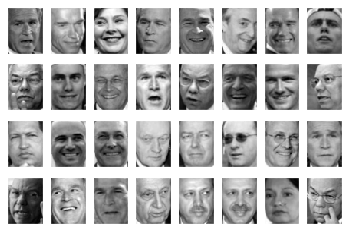

In [5]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

In [6]:
faces.target_names

array([b'Alejandro Toledo', b'Alvaro Uribe', b'Andre Agassi',
       b'Ariel Sharon', b'Arnold Schwarzenegger', b'Colin Powell',
       b'David Beckham', b'Donald Rumsfeld', b'George W Bush',
       b'Gerhard Schroeder', b'Gloria Macapagal Arroyo',
       b'Guillermo Coria', b'Hans Blix', b'Hugo Chavez',
       b'Jacques Chirac', b'Jean Chretien', b'Jennifer Capriati',
       b'John Ashcroft', b'John Negroponte', b'Junichiro Koizumi',
       b'Kofi Annan', b'Laura Bush', b'Lleyton Hewitt',
       b'Luiz Inacio Lula da Silva', b'Megawati Sukarnoputri',
       b'Nestor Kirchner', b'Recep Tayyip Erdogan', b'Roh Moo-hyun',
       b'Serena Williams', b'Silvio Berlusconi', b'Tom Ridge',
       b'Tony Blair', b'Vicente Fox', b'Vladimir Putin'], dtype='|S25')

Nos gustaría poder representar estas imágenes (que están en un espacio 2.914-dimensional) en menor dimensionalidad para poder aprender las relaciones fundamentales entre las imágenes. Una primera forma simple de comenzar sería computar en PCA y examinar la razón de variancia explicada, que nos daría una idea de cuántos componentes principales se requieren para poder describir estos datos.

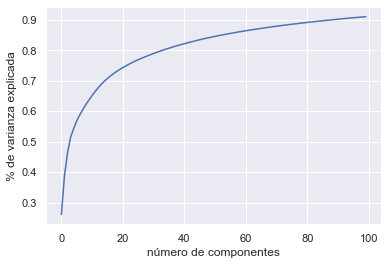

In [7]:
# EJERCICIO: fitear un modelo de PCA conservando 100 componentes principales y plotear 
# el % de varianza explicada en función de la cantidad de componentes

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

StdSclr = StandardScaler()
X = StdSclr.fit_transform(faces.data)

model_pca = PCA(100).fit(X)
plt.plot(np.cumsum(model_pca.explained_variance_ratio_))
plt.xlabel('número de componentes')
plt.ylabel('% de varianza explicada');

Vemos que para este dataset alrededor de 100 componentes principales son necesarios para preservar el 90% de la varianza. Esto nos dice que, en principio, este dataset que es altamente multidimensional no puede ser descripto con pocos componentes lineales (que se obtienen a partir de la X original multiplicando por alguna matriz). 

Cuando este es el caso, métodos de manifold learning como T-SNE o IsoMap pueden ser de mucha ayuda. 

De todos modos comencemos ploteando los datos usando PCA para ver los resultados que obtenemos.

El output es una proyección bidensional de todas las imágenes de input. Para tener una mejor idea de qué nos está diciendo esta proyección, definamos una función que va a plotear thumbnails de las imágenes en las coordenadas de la proyección:

In [8]:
from matplotlib import offsetbox

def plot_components(proj, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    
    fig, ax = plt.subplots(figsize=(10, 10))

    ax = ax or plt.gca()
    
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(proj.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)
            

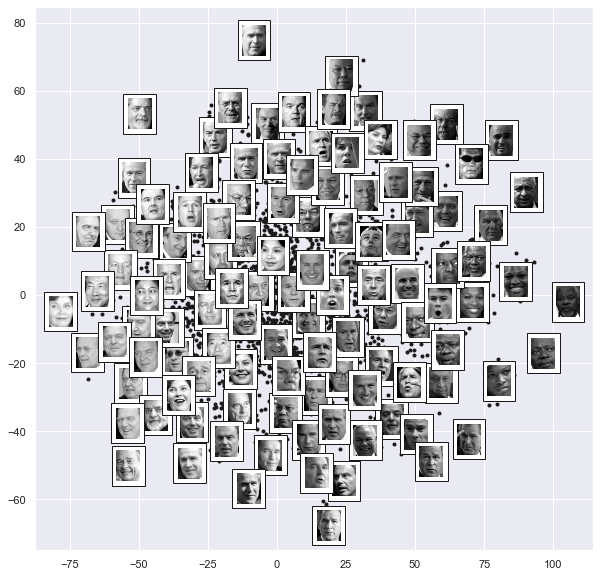

In [9]:
# EJERCICIO: proyectar los datos en 2 dimensiones usando PCA 
# y usar la función para plotear los resultados. Comentar los resultados obtenidos.

pca_2cp = PCA(n_components=2)
proj_pca = pca_2cp.fit_transform(X)

plot_components(proj_pca,
                images=faces.images[:, ::2, ::2])

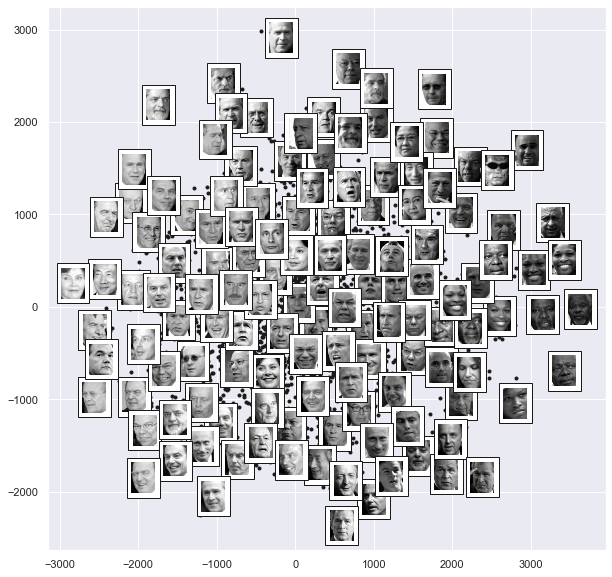

In [10]:
# EJERCICIO: proyectar los datos en 2 dimensiones usando IsoMap
# y usar la función para plotear los resultados. Comentar los resultados obtenidos.

from sklearn.manifold import Isomap

isomap_2cp = Isomap(n_components=2)
proj_iso = pca_2cp.fit_transform(faces.data)

plot_components(proj_iso,
                images=faces.images[:, ::2, ::2])

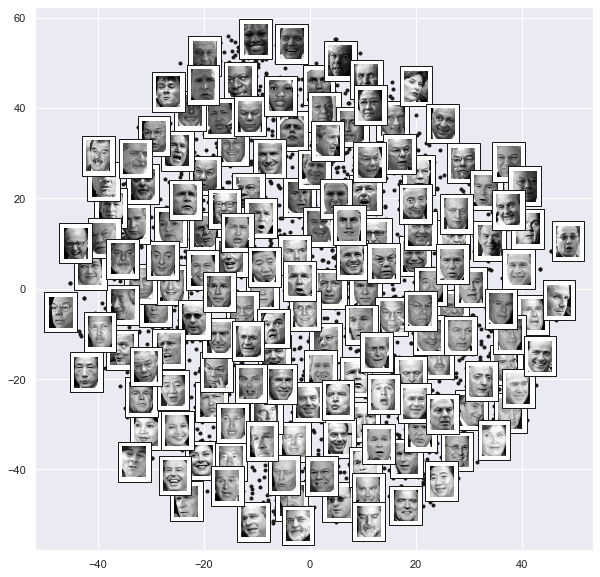

In [11]:
# EJERCICIO: proyectar los datos en 2 dimensiones usando T-SNE
# y usar la función para plotear los resultados. Comentar los resultados obtenidos.

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
proj_tsne = tsne.fit_transform(faces.data)

plot_components(proj_tsne,
                images=faces.images[:, ::2, ::2])

El resultado es interesante: las primeras dos dimensiones del T-SNE parecen describir dos características globales de las imágenes.
    
  * el brillo parece decrecer de abajo hacia arriba
  * la orientación de la cara parece variar de derecha a izquierda

In [12]:
# EJERCICIO: investigar qué otras técnicas de Manifold Learning existen y 
# usarlas para graficar el dataset de caras.